# Technical Requirements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
plt.rc("figure", figsize=(16, 4))

In [2]:
import matplotlib 
import pytorch_lightning as pl
import torch 

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
PyTorch Lightning -> {pl.__version__}
Torch -> {torch.__version__}
''')


Matplotlib -> 3.5.1
pandas -> 1.4.2   
numpy -> 1.22.3
PyTorch Lightning -> 1.6.1
Torch -> 1.11.0



In [3]:
###### configurations for image quality#######
# plt.rcParams["figure.figsize"] = [12, 5]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

In [176]:
path = Path('../../datasets/Ch13/')
# Read the daily_weather.csv 
daily_weather = pd.read_csv(path.joinpath('daily_weather.csv'), 
                      index_col='DateTime', 
                      parse_dates=True)
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['total_energy']
air = pd.read_csv(path.joinpath('air_passenger.csv'), 
                  index_col='date', 
                  parse_dates=True)

daily_weather.ffill(inplace=True)

## Tranform the data sets
### Windowing

In [177]:
def one_step_sliding_window(df, steps):
    d = df.values
    x, y = [], []
    n = len(df)
    idx = df.index[:-steps]
    for start in range(n-steps):
        end = start + steps
        x.append(d[start:end].ravel())
        y.append(d[end])
    cols = [f'x_{i}' for i in range(1, steps+1)]
    x_df = pd.DataFrame(np.array(x), columns=cols, index=idx)
    y_df = pd.Series(np.array(y).reshape(-1), name='y', index=idx)
    return pd.concat([x_df, y_df], axis=1)

In [178]:
sliding_window = 5
air_d = one_step_sliding_window(air, sliding_window)
dw_d = one_step_sliding_window(daily_weather, sliding_window)
en_d = one_step_sliding_window(energy, sliding_window)

### Scale and split data

In [179]:
class Standardize:
    def __init__(self, df, split=0.15):
        self.data = df
        self.split = split
    
    def _split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit(self):
        train, test, val = self._split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]


In [180]:
scale_air = Standardize(air_d)
scale_dw = Standardize(dw_d)
scale_en = Standardize(en_d)

train_air, test_air, val_air = scale_air.fit()
train_dw, test_dw, val_dw = scale_dw.fit()
train_en, test_en, val_en = scale_en.fit()

In [181]:
print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')


air: train: 102 , test: 20, val:17
weather: train: 2109 , test: 437, val:372
energy: train: 422 , test: 87, val: 74



### Split into X and Y (Features and Target)

In [182]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [183]:
def features_target(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

In [184]:
def features_target(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float()
                   for col in args]
    return *y, *x

In [185]:
(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target(train_air, 
                               val_air, 
                               test_air)

(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target(train_dw, 
                             val_dw, 
                             test_dw)

(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target(train_en, 
                             val_en, 
                             test_en)

In [186]:
y_train_air.shape

torch.Size([102, 1])

In [187]:
x_train_air.shape

torch.Size([102, 5, 1])

# RNN/LSTM in PyTorch

$$\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}
$$

In [87]:
from torch.utils.data import DataLoader

In [101]:
train_loader = DataLoader(x_train_air, batch_size=3, shuffle=False)

In [126]:
x_train_air.shape

torch.Size([102, 5])

In [127]:
x = next(iter(train_loader))
x.shape

torch.Size([3, 5])

In [226]:
x

LSTM(102, 5)

In [251]:
from torch.autograd import Variable
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = (torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = (torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
lstm.train()
# Train the model
for epoch in range(num_epochs):
    outputs = lstm(x_train_dw)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, y_train_dw)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.89810
Epoch: 100, loss: 0.40689
Epoch: 200, loss: 0.38731
Epoch: 300, loss: 0.37964
Epoch: 400, loss: 0.37446
Epoch: 500, loss: 0.37100
Epoch: 600, loss: 0.36713
Epoch: 700, loss: 0.36432
Epoch: 800, loss: 0.36252
Epoch: 900, loss: 0.36099
Epoch: 1000, loss: 0.35958
Epoch: 1100, loss: 0.35816
Epoch: 1200, loss: 0.35671
Epoch: 1300, loss: 0.35539
Epoch: 1400, loss: 0.35457
Epoch: 1500, loss: 0.35403
Epoch: 1600, loss: 0.35362
Epoch: 1700, loss: 0.35329
Epoch: 1800, loss: 0.35303
Epoch: 1900, loss: 0.35281


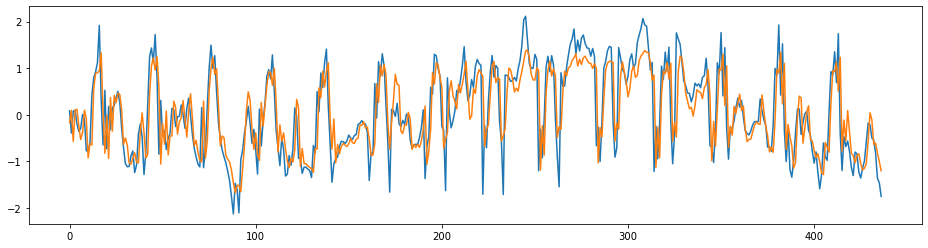

In [252]:
plt.plot(y_test_dw.data.numpy() )
plt.plot(lstm(x_test_dw).data.numpy() )

In [237]:
lstm.eval()
lstm(x_test_air)

tensor([[1.3100],
        [1.3842],
        [1.4736],
        [1.5191],
        [1.5223],
        [1.4650],
        [1.3494],
        [1.1288],
        [1.3368],
        [1.3772],
        [1.2885],
        [1.3815],
        [1.4611],
        [1.4744],
        [1.5150],
        [1.5316],
        [1.5302],
        [1.5032],
        [1.4625],
        [1.2859]], grad_fn=<AddmmBackward0>)

In [210]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = 5
        self.dr = 0.2
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True, dropout=self.dr)
        self.dropout = nn.Dropout(self.dr)
        self.fc = nn.Linear(hidden_size, self.output_size)
    
    def forward(self, x, h):
        batch_size = x.size(0)
        
        x_out, h = self.lstm(x, h)
        x_out = self.dropout(x_out)
        x_out = x_out.view(-1, self.hidden_size)
        out = self.fc(x_out)
        return out, h

    def init_hidden(self, batch_size):
        return (torch.zeros(self.input_size, batch_size, self.hidden_size),
                torch.zeros(self.input_size, batch_size, self.hidden_size))

In [201]:
x_train_air.shape
x = nn.LSTM(102, 5, 1)
h0 = torch.zeros(102, 5, 1)
c0 = torch.zeros(102, 5, 1)
h0.shape == x_train_air.shape


True

In [240]:
def train_batch(x_train, y_train, 
                x_val, 
                y_val, 
                epochs=1000, 
                batch_size=32, 
                lr=0.001):
    input_size = x_train.shape[0]
    hidden_size = x_train.shape[1]
    output_size = 1
    
    model = LSTM(input_size, hidden_size, output_size, 5)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    losses = []
    val_losses = []
    

    for epoch in range(epochs):
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        print(h[0].shape)
        model.zero_grad()
        y_pred, h = model(x_train, h)

        loss = criterion(y_pred, y_train)
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 10 == 0:
            model.eval()
            val_h = model.init_hidden(batch_size)
            y_pred_val, val_h = model(x_val, val_h)
            val_loss = criterion(y_pred_val, y_val)
            
            losses.append(loss.item())
            val_lossess.append(val_loss.item())
    
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {val_loss.item():.4f}')
    return history, y_pred, model

In [241]:
history_air, y_pred_air, model_air = train_batch(x_train_air, 
                                                 y_train_air, 
                                                 x_val_air, 
                                                 y_val_air, 
                                                 batch_size=32)

AttributeError: 'LSTM' object has no attribute 'init_hidden'

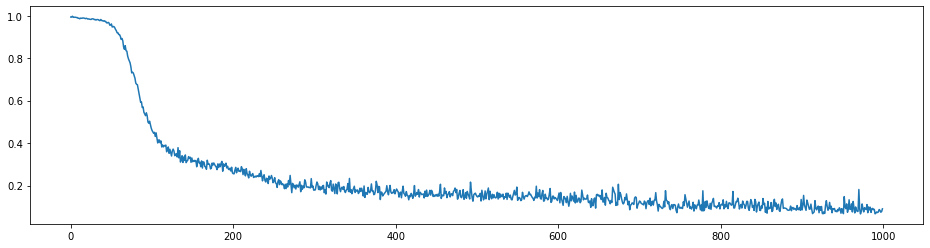

In [79]:
plt.plot([i.detach().numpy() for i in history_air])

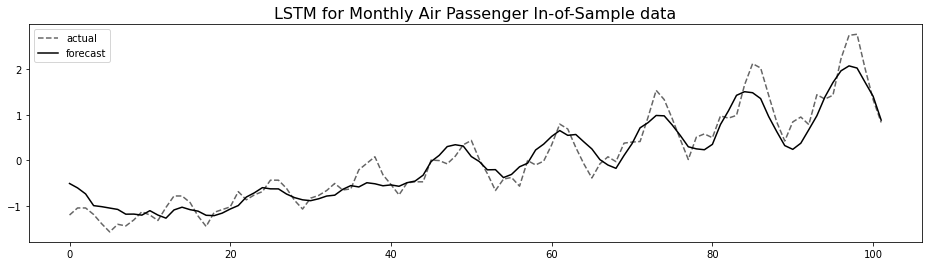

In [47]:
plt.title("LSTM for Monthly Air Passenger (In-of-Sample data)")
plt.plot(y_train_air, 'k--', label='actual', alpha=0.6)
plt.plot(y_pred_air.detach().numpy(), 'k', label='forecast')
plt.legend(); plt.show()

In [25]:
model_air.eval()
y_hat_air = model_air(x_test_air)
# evaluate on y_test
mse = nn.MSELoss()
mse_loss_air = mse(y_hat_air, y_test_air)
print(f'MSE Loss: {mse_loss_air.item():.4f}')

MSE Loss: 6.3653


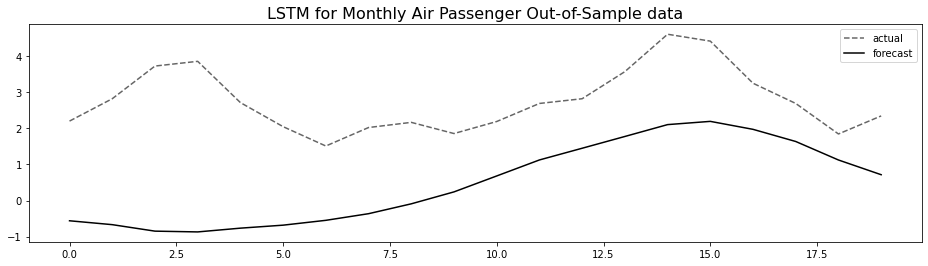

In [46]:
plt.title("LSTM for Monthly Air Passenger (Out-of-Sample data)")
plt.plot(y_test_air, 'k--', label='actual', alpha=0.6)
plt.plot(y_hat_air.detach().numpy(), 'k', label='forecast')
plt.legend(); plt.show()

In [38]:
x_train_dw.shape

torch.Size([102, 5])

In [28]:
history_dw, y_pred_dw, model_dw = train_batch(x_train_dw, y_train_dw, epochs=1000, batch_size=64)

Epoch [50/500], Loss: 0.9978
Epoch [100/500], Loss: 0.8850
Epoch [150/500], Loss: 0.7898
Epoch [200/500], Loss: 0.7826
Epoch [250/500], Loss: 0.7852
Epoch [300/500], Loss: 0.7772
Epoch [350/500], Loss: 0.7751
Epoch [400/500], Loss: 0.7719
Epoch [450/500], Loss: 0.7757
Epoch [500/500], Loss: 0.7682


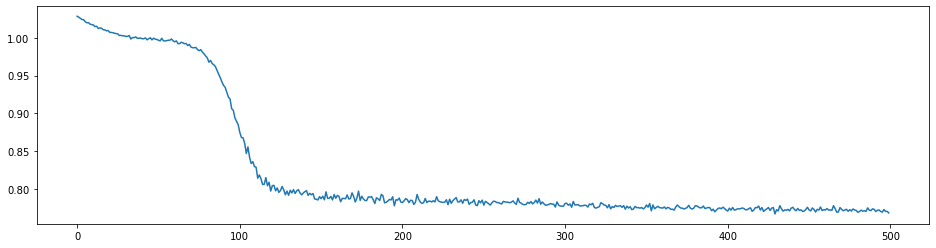

In [53]:
plt.plot([i.detach().numpy() for i in history_dw])

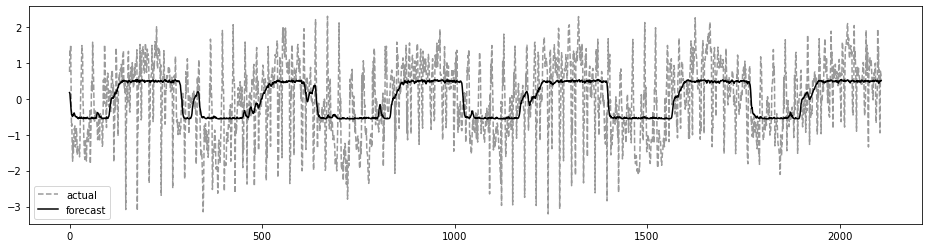

In [29]:
plt.title("LSTM for Avg Daily Weather (In-of-Sample data)")
plt.plot(y_train_dw, 'k--', label='actual', alpha=0.40)
plt.plot(y_pred_dw.detach().numpy(), 'k', label='forecast')
plt.legend(); plt.show()

In [30]:
y_hat_dw = model_dw(x_test_dw)
# evaluate on y_test
mse = nn.MSELoss()
mse_loss_dw = mse(y_hat_dw, y_test_dw)
print(f'MSE Loss: {mse_loss_dw.item():.4f}')

MSE Loss: 0.7280


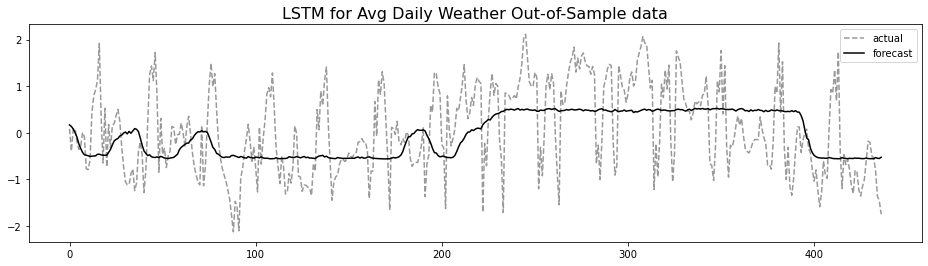

In [42]:
plt.title("LSTM for Avg Daily Weather (Out-of-Sample data)")
plt.plot(y_test_dw, 'k--', label='actual', alpha=0.40)
plt.plot(y_hat_dw.detach().numpy(), 'k', label='forecast')
plt.legend(); plt.show()

In [32]:
history_en, y_pred_en, model_en = train_batch(x_train_en, y_train_en, epochs=500, batch_size=64)

Epoch [50/500], Loss: 0.9874
Epoch [100/500], Loss: 0.8012
Epoch [150/500], Loss: 0.7711
Epoch [200/500], Loss: 0.7259
Epoch [250/500], Loss: 0.4959
Epoch [300/500], Loss: 0.4157
Epoch [350/500], Loss: 0.3949
Epoch [400/500], Loss: 0.3398
Epoch [450/500], Loss: 0.3057
Epoch [500/500], Loss: 0.2794


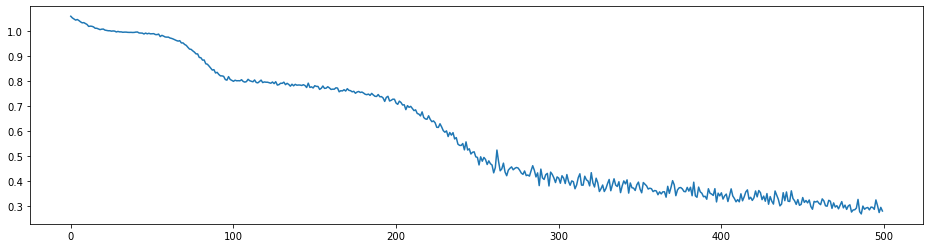

In [54]:
plt.plot([i.detach().numpy() for i in history_en])

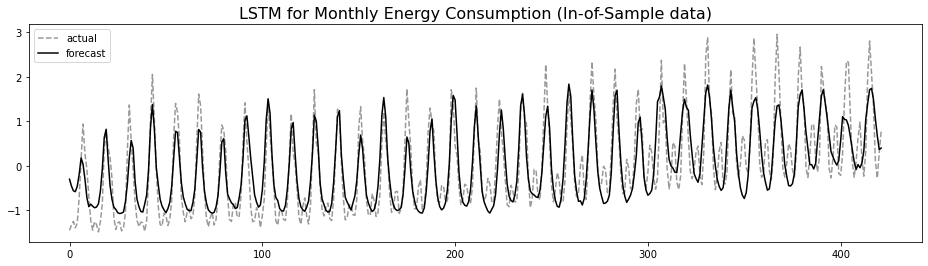

In [51]:
plt.title("LSTM for Monthly Energy Consumption (In-of-Sample data)")
plt.plot(y_train_en, 'k--', label='actual', alpha=0.40)
plt.plot(y_pred_en.detach().numpy(), 'k', label='forecast')
plt.legend(); plt.show()

In [34]:
y_hat_en = model_en(x_test_en)
# evaluate on y_test
mse = nn.MSELoss()
mse_loss_en = mse(y_hat_en, y_test_en)
print(f'MSE Loss: {mse_loss_en.item():.4f}')

MSE Loss: 0.9834


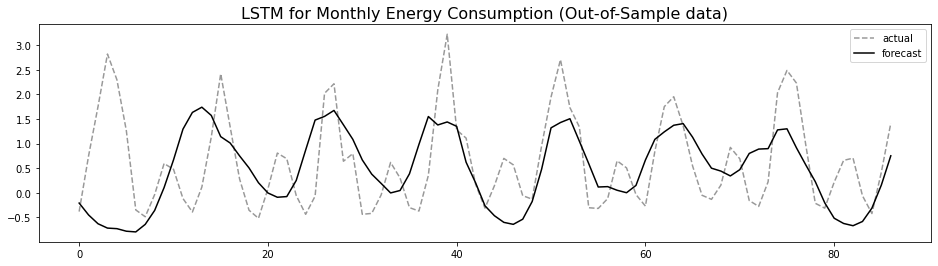

In [50]:
plt.title("LSTM for Monthly Energy Consumption (Out-of-Sample data)")
plt.plot(y_test_en, 'k--', label='actual', alpha=0.40)
plt.plot(y_hat_en.detach().numpy(), 'k', label='forecast')
plt.legend(); plt.show()